# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — количество недвижимости у клиента
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак

    Exited — факт ухода клиента

# 1. Подготовка данных

Загрузим и подготовим данные. А также обновим/добавим библиотеки.

In [1]:
pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.8 MB 49 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 167 kB 805 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Можем увидеть, что данные в модели разных типов, а также есть пропуски в Tenure. Можно предположить, что не заполнены значения, потому что нет недвижимости у клиента. Заполним нулями.<br>
Столбцы RowNumber, CustomerId и Surname для обучения модели не информативны, их из датасета можем исключить.

In [5]:
df = df.fillna(0)
df = df.drop(['RowNumber', 'CustomerId', 'Surname'] , axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


# 2. Исследование задачи

Исследуем баланс классов.<br>
Видно, что классы не сбалансированы.

In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

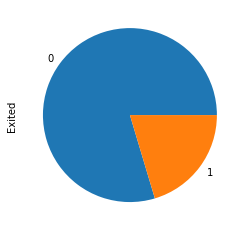

In [24]:
df['Exited'].value_counts().plot.pie()

Нам предстоит решить задачу бинарной классификации, поэтому для кодирования признаков применим OrdinalEncoder.<br>
Загрузим модели из sklearn и пропустим наши данные без гиперпараметров.

In [7]:
encoder = OrdinalEncoder()

features = df.drop(['Exited'], axis=1)
target = df['Exited']

features_ordinal = pd.DataFrame(encoder.fit_transform(features), columns=features.columns)

# Сохраняем тестовую выборку.
features, features_test, target, target_test = train_test_split(
    features_ordinal, target, test_size=0.20, random_state=12)

# Валидационную.
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


def model(model_i):
    model = model_i 
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    print(f'model = {model}') 
    print(f'f1 = {f1_score(target_valid, predict_valid)}')
    print(f'AUC-ROC = {roc_auc_score(target_valid, predict_valid)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_valid, predict_valid)} \n')


model(RandomForestClassifier(random_state=12))
model(DecisionTreeClassifier(random_state=12))
model(AdaBoostClassifier(random_state=12))
model(GradientBoostingClassifier(random_state=12))

model = RandomForestClassifier(random_state=12)
f1 = 0.5620094191522763
AUC-ROC = 0.7056250000000001 

TN FP / FN TP 
 [[1542   58]
 [ 221  179]] 

model = DecisionTreeClassifier(random_state=12)
f1 = 0.4678217821782178
AUC-ROC = 0.6678125 

TN FP / FN TP 
 [[1381  219]
 [ 211  189]] 

model = AdaBoostClassifier(random_state=12)
f1 = 0.5701357466063348
AUC-ROC = 0.713125 

TN FP / FN TP 
 [[1526   74]
 [ 211  189]] 

model = GradientBoostingClassifier(random_state=12)
f1 = 0.6009244992295839
AUC-ROC = 0.726875 

TN FP / FN TP 
 [[1546   54]
 [ 205  195]] 



### Вывод

Модели на дисбалансированных данных отработали по разному.<br>
Достойно - RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier.

# 3. Борьба с дисбалансом

Улучшим качество модели, учитывая дисбаланс классов.<br>
Используем библиотеку imbalanced-learn.

In [9]:
# Андерсэмплинг с использованием Tomek Links и тестовыми данными.

from imblearn.under_sampling import TomekLinks

tl = TomekLinks(n_jobs=-1)
features_tl, target_tl = tl.fit_resample(features, target)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_tl, target_tl, test_size=0.25, random_state=12)

In [10]:
def model(model_i):
    model = model_i 
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    print(f'model = {model}') 
    print(f'f1 = {f1_score(target_valid, predict_valid)}')
    print(f'AUC-ROC = {roc_auc_score(target_valid, predict_valid)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_valid, predict_valid)} \n')


model(RandomForestClassifier(random_state=12))
model(DecisionTreeClassifier(random_state=12))
model(AdaBoostClassifier(random_state=12))
model(GradientBoostingClassifier(random_state=12))

model = RandomForestClassifier(random_state=12)
f1 = 0.5305466237942122
AUC-ROC = 0.6879366458095406 

TN FP / FN TP 
 [[1365   66]
 [ 226  165]] 

model = DecisionTreeClassifier(random_state=12)
f1 = 0.50126582278481
AUC-ROC = 0.6829663229798345 

TN FP / FN TP 
 [[1230  201]
 [ 193  198]] 

model = AdaBoostClassifier(random_state=12)
f1 = 0.5508607198748043
AUC-ROC = 0.6999067059145233 

TN FP / FN TP 
 [[1359   72]
 [ 215  176]] 

model = GradientBoostingClassifier(random_state=12)
f1 = 0.5631067961165048
AUC-ROC = 0.7039878753433741 

TN FP / FN TP 
 [[1378   53]
 [ 217  174]] 



In [11]:
# Оверсэмплинг со SMOTE и тестовыми данными.

from imblearn.over_sampling import SMOTE

smote = SMOTE(n_jobs=-1)
features_sm, target_sm = smote.fit_sample(features, target)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_sm, target_sm, test_size=0.25, random_state=12)

In [12]:
def model(model_i):
    model = model_i 
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    print(f'model = {model}') 
    print(f'f1 = {f1_score(target_valid, predict_valid)}')
    print(f'AUC-ROC = {roc_auc_score(target_valid, predict_valid)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_valid, predict_valid)} \n')


model(RandomForestClassifier(random_state=12))
model(DecisionTreeClassifier(random_state=12))
model(AdaBoostClassifier(random_state=12))
model(GradientBoostingClassifier(random_state=12))

model = RandomForestClassifier(random_state=12)
f1 = 0.9044025157232706
AUC-ROC = 0.9059653427508346 

TN FP / FN TP 
 [[1458   95]
 [ 209 1438]] 

model = DecisionTreeClassifier(random_state=12)
f1 = 0.8644888082274652
AUC-ROC = 0.8597688395963549 

TN FP / FN TP 
 [[1323  230]
 [ 218 1429]] 

model = AdaBoostClassifier(random_state=12)
f1 = 0.8939774153074027
AUC-ROC = 0.8952576656966891 

TN FP / FN TP 
 [[1437  116]
 [ 222 1425]] 

model = GradientBoostingClassifier(random_state=12)
f1 = 0.9034287511796163
AUC-ROC = 0.9050362207076341 

TN FP / FN TP 
 [[1457   96]
 [ 211 1436]] 



### Вывод

Андерсэмплинг показывает примерно такие же результаты на валидационной выборке, как и без работы с дисбалансом.<br> 
Оверсэмплинг показывает очень впечатляющие результаты на валидационной выборке, но это из-за переобучения.<br>
Возьмем топ модели для тестирования.

# 4. Тестирование моделей

Проведем финальное тестирование.<br>
Обучим модели с учетом дисбаланса.

In [13]:
def model(model_i):
    model = model_i
    model.fit(features_tl, target_tl)
    predict_test = model.predict(features_test)
    print('TomekLinks')
    print(f'model = {model}') 
    print(f'f1 = {f1_score(target_test, predict_test)}')
    print(f'AUC-ROC = {roc_auc_score(target_test, predict_test)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_test, predict_test)} \n')
    
    model = model_i
    model.fit(features_sm, target_sm)
    predict_test = model.predict(features_test)
    print('SMOTE')
    print(f'model = {model}') 
    print(f'f1 = {f1_score(target_test, predict_test)}')
    print(f'AUC-ROC = {roc_auc_score(target_test, predict_test)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_test, predict_test)} \n')
    
    
model(RandomForestClassifier(random_state=12))
model(DecisionTreeClassifier(random_state=12))
model(AdaBoostClassifier(random_state=12))
model(GradientBoostingClassifier(random_state=12))

TomekLinks
model = RandomForestClassifier(random_state=12)
f1 = 0.6282578875171467
AUC-ROC = 0.7421543208428166 

TN FP / FN TP 
 [[1500   64]
 [ 207  229]] 

SMOTE
model = RandomForestClassifier(random_state=12)
f1 = 0.6208791208791209
AUC-ROC = 0.7380745676810812 

TN FP / FN TP 
 [[1498   66]
 [ 210  226]] 

TomekLinks
model = DecisionTreeClassifier(random_state=12)
f1 = 0.5039908779931584
AUC-ROC = 0.6831078861540627 

TN FP / FN TP 
 [[1344  220]
 [ 215  221]] 

SMOTE
model = DecisionTreeClassifier(random_state=12)
f1 = 0.5405405405405406
AUC-ROC = 0.7074544217367841 

TN FP / FN TP 
 [[1352  212]
 [ 196  240]] 

TomekLinks
model = AdaBoostClassifier(random_state=12)
f1 = 0.5845737483085252
AUC-ROC = 0.7198931227856121 

TN FP / FN TP 
 [[1477   87]
 [ 220  216]] 

SMOTE
model = AdaBoostClassifier(random_state=12)
f1 = 0.5937888198757764
AUC-ROC = 0.7325224665055491 

TN FP / FN TP 
 [[1434  130]
 [ 197  239]] 

TomekLinks
model = GradientBoostingClassifier(random_state=12)
f1 = 0

Андерсэмплинг показал преимущество только с RandomForestClassifier.<br>
Оверсэмплинг показывает лучшие результаты, потому что имеется возможность модели обучиться без дисбаланса на большЕм количестве данных.<br>
Цель f1 = 0.59 выполняется почти у всех моделей.<br>
Попробуем гиперпараметрами улучшить качество моделей.

#### RandomForestClassifier

In [14]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

def best_model(features_bm, target_bm, name_model):
    params = {
        'class_weight' : ['balanced', 'balanced_subsample'],
        'n_estimators' : range(100, 175, 25),
        'min_samples_split' : range(2, 10, 4),
        'oob_score' : [False, True]
        } 


    model = RandomForestClassifier(random_state=12)
    model_cv = GridSearchCV(model, params, n_jobs=-1)

    model_cv.fit(features_bm, target_bm)
    predict_test = model_cv.predict(features_test)

    print(name_model)
    print(model_cv.best_params_)
    print(f'f1 = {f1_score(target_test, predict_test)}')
    print(f'AUC-ROC = {roc_auc_score(target_test, predict_test)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_test, predict_test)} \n')
    
best_model(features_tl, target_tl, 'TomekLinks')

TomekLinks
{'class_weight': 'balanced_subsample', 'min_samples_split': 6, 'n_estimators': 150, 'oob_score': False}
f1 = 0.6381322957198443
AUC-ROC = 0.7536574063211243 

TN FP / FN TP 
 [[1475   89]
 [ 190  246]] 



In [15]:
best_model(features_sm, target_sm, 'SMOTE')

SMOTE
{'class_weight': 'balanced_subsample', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False}
f1 = 0.6132971506105834
AUC-ROC = 0.7351973298294188 

TN FP / FN TP 
 [[1489   75]
 [ 210  226]] 



#### DecisionTreeClassifier

In [16]:
def best_model(features_bm, target_bm, name_model):
    params = {
        'min_samples_split' : range(2, 10, 4),
        'min_samples_leaf': range(5, 30, 5),
        'class_weight' : ['balanced'],
        'splitter' : ['best', 'random'],
        } 


    model = DecisionTreeClassifier(random_state=12)
    model_cv = GridSearchCV(model, params, n_jobs=-1)

    model_cv.fit(features_bm, target_bm)
    predict_test = model_cv.predict(features_test)

    print(model_cv.best_params_)
    print(name_model)
    print(f'f1 = {f1_score(target_test, predict_test)}')
    print(f'AUC-ROC = {roc_auc_score(target_test, predict_test)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_test, predict_test)} \n')
    
best_model(features_tl, target_tl, 'TomekLinks')

{'class_weight': 'balanced', 'min_samples_leaf': 25, 'min_samples_split': 2, 'splitter': 'best'}
TomekLinks
f1 = 0.5857519788918205
AUC-ROC = 0.7642336751214247 

TN FP / FN TP 
 [[1196  368]
 [ 103  333]] 



In [17]:
best_model(features_sm, target_sm, 'SMOTE')

{'class_weight': 'balanced', 'min_samples_leaf': 25, 'min_samples_split': 2, 'splitter': 'best'}
SMOTE
f1 = 0.5960591133004927
AUC-ROC = 0.7346840610995097 

TN FP / FN TP 
 [[1430  134]
 [ 194  242]] 



#### AdaBoostClassifier

In [18]:
def best_model(features_bm, target_bm, name_model):
    params = {
        'base_estimator' : [
            RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=6, n_estimators=150)],
        'n_estimators' : range(1, 9, 2)
        } 


    model = AdaBoostClassifier(random_state=12)
    model_cv = GridSearchCV(model, params, n_jobs=-1)

    model_cv.fit(features_bm, target_bm)
    predict_test = model_cv.predict(features_test)

    print(model_cv.best_params_)
    print(name_model)
    print(f'f1 = {f1_score(target_test, predict_test)}')
    print(f'AUC-ROC = {roc_auc_score(target_test, predict_test)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_test, predict_test)} \n')
    
best_model(features_tl, target_tl, 'TomekLinks')

{'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=6,
                       n_estimators=150), 'n_estimators': 3}
TomekLinks
f1 = 0.6248294679399727
AUC-ROC = 0.7408755484643 

TN FP / FN TP 
 [[1496   68]
 [ 207  229]] 



In [19]:
best_model(features_sm, target_sm, 'SMOTE')

{'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=6,
                       n_estimators=150), 'n_estimators': 3}
SMOTE
f1 = 0.6209790209790209
AUC-ROC = 0.7363646495694408 

TN FP / FN TP 
 [[1507   57]
 [ 214  222]] 



#### GradientBoostingClassifier

In [20]:
def best_model(features_bm, target_bm, name_model):
    params = {
        'loss' : ['deviance', 'exponential'],
        'learning_rate' : np.arange(0.1, 0.5, 0.2),
        'n_estimators' : range(100, 200, 50),
        'subsample' : np.arange(0.1, 0.5, 0.2),
        'min_samples_split' : range(2, 10, 4),
        'min_samples_leaf' : range(1, 9, 4)
        } 


    model = GradientBoostingClassifier(random_state=12)
    model_cv = GridSearchCV(model, params, n_jobs=-1)

    model_cv.fit(features_bm, target_bm)
    predict_test = model_cv.predict(features_test)

    print(model_cv.best_params_)
    print(name_model)
    print(f'f1 = {f1_score(target_test, predict_test)}')
    print(f'AUC-ROC = {roc_auc_score(target_test, predict_test)} \n')
    print(f'TN FP / FN TP \n {confusion_matrix(target_test, predict_test)} \n')
    
best_model(features_tl, target_tl, 'TomekLinks')

{'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150, 'subsample': 0.30000000000000004}
TomekLinks
f1 = 0.6071428571428571
AUC-ROC = 0.730742157253807 

TN FP / FN TP 
 [[1493   71]
 [ 215  221]] 



In [21]:
best_model(features_sm, target_sm, 'SMOTE')

{'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150, 'subsample': 0.30000000000000004}
SMOTE
f1 = 0.6306306306306306
AUC-ROC = 0.7502727656678946 

TN FP / FN TP 
 [[1468   96]
 [ 191  245]] 



### Вывод

У некоторых моделей удалось улучшить точность с помощью гиперпараметров.<br>
Самое сильное влияние можно увидеть по DecisionTreeClassifier.